# AIPI 590 - XAI | Assignment #10
### XAI in LLMs
### Shaunak Badani

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shaunak-badani/XAI/blob/main/Assignment10/XAI_in_LLMs.ipynb)

> This repository contains:
1. XAI in prompting with saliency scores
2. Embedding vectors mapped to 2 dimensions using t-SNE and UMAP.

# 1. XAI in prompting with Saliency methods

- In this notebook I will use the method of vanilla gradients to help generate explanations for a model prompt from a sentiment analysis model

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from IPython.display import display, HTML
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE

In [2]:
MODEL_NAME = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


- We first pass the sentence through the tokenizer, then get the maximum logit of the output to get which of the three logits was the greatest.
- Then we use the logit to perform a backward pass, which computes the gradients.
- The gradients are within the embedding layer.
- We take the gradients of the 768 dimensions, and sum those values to get the effective weight of a single token.

In [3]:
sample_text = "This review is amazing!"
input_ids = tokenizer(sample_text, return_tensors="pt")
output_ids = model(**input_ids)
predicted_class_index = torch.argmax(output_ids.logits)
max_val = torch.max(output_ids.logits)
print(max_val)
max_val.backward()
# predicted_class_index.backward()
labels = ['negative', 'neutral', 'positive']
predicted_sentiment = labels[predicted_class_index]
print("Predicted Sentiment:", predicted_sentiment)

tensor(3.8919, grad_fn=<MaxBackward1>)
Predicted Sentiment: positive


In [4]:
indices = input_ids['input_ids'][0]
print(indices)

tensor([    0,   126,  2274,    17, 36148,    12,     2])


In [5]:
gradients = model.roberta.embeddings.word_embeddings.weight.grad[indices]
input_weights = torch.abs(gradients.sum(axis = 1))

tokens = np.array(list(map(lambda x: tokenizer.decode(x), input_ids['input_ids'][0])))[1:-1]
weights = input_weights.numpy()

- Write a function that can color code based onthe weights given to it:

In [6]:
def visualize_token_attrs(tokens, attrs):
    """
      Visualize attributions for given set of tokens.
      Args:
      - tokens: An array of tokens
      - attrs: An array of attributions, of same size as 'tokens',
        with attrs[i] being the attribution to tokens[i]

      Returns:
      - visualization: An IPython.core.display.HTML object showing
        tokens color-coded based on strength of their attribution.
    """
    def get_color(attr):
        if attr > 0:
            g = int(128*attr) + 127
            b = 128 - int(64*attr)
            r = 128 - int(64*attr)
        else:
            g = 128 + int(64*attr)
            b = 128 + int(64*attr)
            r = int(-128*attr) + 127
        return r,g,b

    # normalize attributions for visualization.
    bound = max(abs(attrs.max()), abs(attrs.min()))
    attrs = attrs/bound
    html_text = ""
    for i, tok in enumerate(tokens):
        r, g, b = get_color(attrs[i])
        html_text += " <span style='color:rgb(%d,%d,%d)'>%s</span>" % \
                     (r, g, b, tok)
    return HTML(html_text)

In [7]:
display(visualize_token_attrs(tokens, weights))

- Encode all of the above logic in a function.

In [8]:
def visualize_sentence(sentence):
  # zero out gradients before running inference on the next sentence
  for param in model.parameters():
    if param.grad is not None:
        param.grad.zero_()

  input_ids = tokenizer(sentence, return_tensors="pt")
  output_ids = model(**input_ids)
  predicted_class_index = torch.argmax(output_ids.logits)
  max_val = torch.max(output_ids.logits)
  max_val.backward()
  labels = ['negative', 'neutral', 'positive']
  predicted_sentiment = labels[predicted_class_index]
  print("Predicted sentiment: ", predicted_sentiment)
  indices = input_ids['input_ids'][0]
  gradients = model.roberta.embeddings.word_embeddings.weight.grad[indices]
  input_weights = torch.abs(gradients.sum(axis = 1))

  tokens = np.array(list(map(lambda x: tokenizer.decode(x), input_ids['input_ids'][0])))[1:-1]
  weights = input_weights.numpy()

  display(visualize_token_attrs(tokens, weights))


In [9]:
visualize_sentence("I did not like the food!")

Predicted sentiment:  negative


- As can be seen, the word "not" had a huge impact on the sentiment of the above sentence being negative.

In [10]:
# some more examples

sentences = [
    "I absolutely love this product!",
    "The book was okay, not too bad, but not great either.",
    "The customer service was terrible, they didn’t help at all.",
    "I didn’t like the food at all, it was tasteless.",
    "The experience was horrible, I will never visit again.",
    "I regret buying this phone, it doesn’t meet my expectations.",
    "I’m waiting for the bus to arrive.",
    "I went to the store and bought some groceries.",
    "I hate how slow my internet is today.",
    "The movie was fantastic, I highly recommend it.",
    "This phone is amazing, so smooth and fast!",
    "I had a wonderful day at the beach with my friends.",
    "The weather is quite average today, not too hot or cold.",
    "I’m really upset about how my team performed in the game.",
]

In [11]:
for sentence in sentences:
  visualize_sentence(sentence)

Predicted sentiment:  positive


Predicted sentiment:  neutral


Predicted sentiment:  negative


Predicted sentiment:  negative


Predicted sentiment:  negative


Predicted sentiment:  negative


Predicted sentiment:  neutral


Predicted sentiment:  neutral


Predicted sentiment:  negative


Predicted sentiment:  positive


Predicted sentiment:  positive


Predicted sentiment:  positive


Predicted sentiment:  neutral


Predicted sentiment:  negative


# 2. Using U-MAP, t-SNE and PCA to project embedding space into 2 dimensions and visualize the outputs.

In [12]:
MODEL_NAME = "jinaai/jina-embeddings-v2-base-en"
model = SentenceTransformer(MODEL_NAME)

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-en and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.intermedi

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
vocab_dict = tokenizer.get_vocab()
input_ids = torch.tensor([np.arange(len(vocab_dict))])
words = list(vocab_dict.keys())

In [19]:
words_interested = {
    "food": ["tomato", "potato", "bread", "apple", "banana"],
    "animals": ["dog", "cat", "fish", "bird", "cow"],
    "colors": ["red", "blue", "green", "black", "white"],
    "emotions": ["happy", "sad", "angry", "calm", "proud"],
    "vehicles": ["car", "bike", "bus", "train", "ship"],
    "sports": ["golf", "tennis", "chess", "boxing", "swim"],
    "tools": ["hammer", "drill", "saw", "nail"],
    "body_parts": ["head", "hand", "leg", "eye", "ear"],
    "nature": ["tree", "rock", "river", "cloud", "wind"],
    "technology": ["phone", "laptop", "mouse", "code", "robot"]
}

In [21]:
embeddings = {}

for category, queries in words_interested.items():
  embeddings[category] = model.encode(queries, normalize_embeddings = True)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


1. PCA

- PCA is a dimensionality reduction technique that uses a data and then finds its eigenvalues and eigenvectors.
- Eigenvectors corresponding to top K of these eigenvalues are selected, forming a new lower-dimensional space.
- The original data is then projected onto these top K eigenvectors to obtain a reduced-dimensional representation.

In [22]:
X = np.vstack(list(embeddings.values()))

pca = PCA(n_components = 2, svd_solver = 'full')
pca.fit(X)
projected_embeddings = {}

for category, embedding in embeddings.items():
  projected_embeddings[category] = pca.transform(embedding)

Text(0.5, 1.0, 'PCA on projected embeddings for different categories')

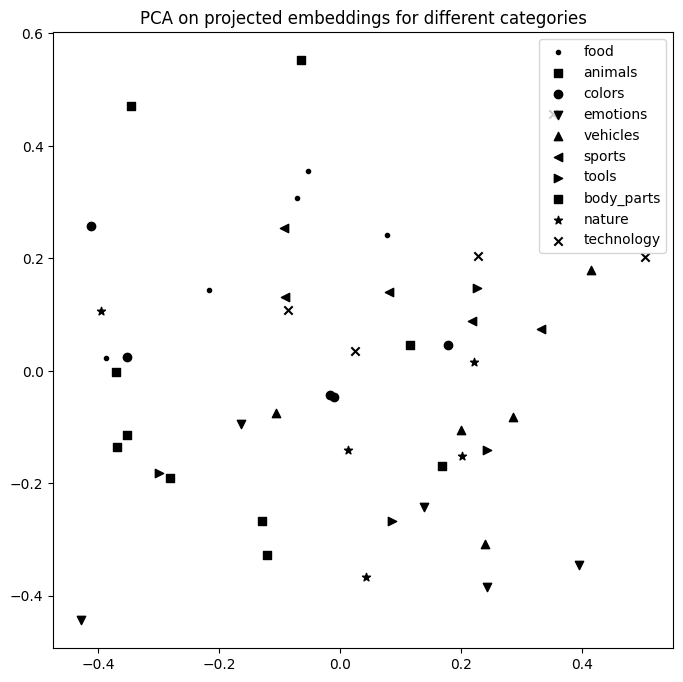

In [23]:
fig = plt.figure(figsize = (8, 8))
markers = ['.', ',', 'o', 'v', '^', '<', '>', 's', '*', 'x', 'D', 'd', 'p', 'h', 'H', '+', '|', '_']
for i, (category, projected_embedding) in enumerate(projected_embeddings.items()):
  plt.scatter(projected_embedding[:, 0], projected_embedding[:, 1], label = category, marker = markers[i], color = "black")
plt.legend(loc = 'best')
plt.title("PCA on projected embeddings for different categories")

- As can be seen, there is no distinct categorization with PCA for different categories

2. UMAP



In [24]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
reducer.fit(X)
umap_projections = {}
for category, embedding in embeddings.items():
  umap_projections[category] = reducer.transform(embedding)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Text(0.5, 1.0, 'UMAP on projected embeddings for different categories')

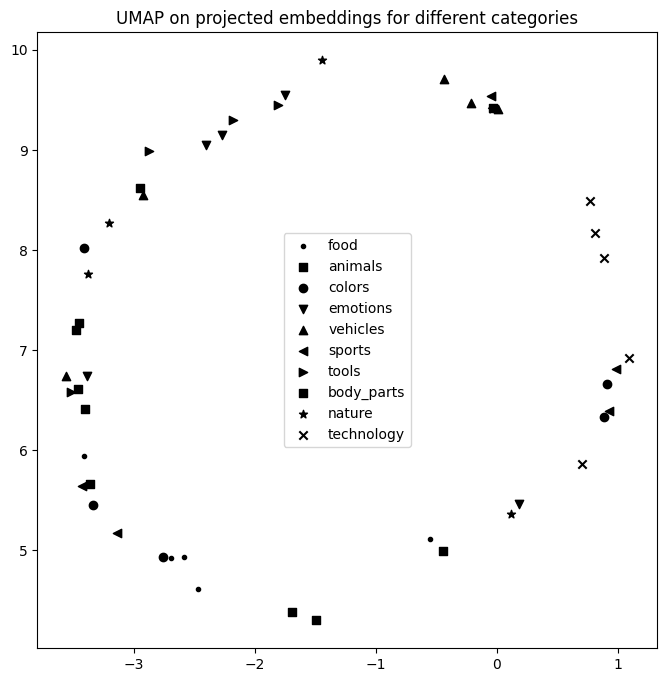

In [25]:
fig = plt.figure(figsize = (8, 8))
markers = ['.', ',', 'o', 'v', '^', '<', '>', 's', '*', 'x', 'D', 'd', 'p', 'h', 'H', '+', '|', '_']
for i, (category, projected_embedding) in enumerate(umap_projections.items()):
  plt.scatter(projected_embedding[:, 0], projected_embedding[:, 1], label = category, marker = markers[i], color = "black")
plt.legend(loc = 'best')
plt.title("UMAP on projected embeddings for different categories")

- Slightly more structured projections can be seen above.
- Technology vectors are close to each other, and so are some body_parts.

3. t-SNE



In [26]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

X_projected = tsne.fit_transform(X)
i = 0
tsne_projections = {}

for category, word_list in words_interested.items():
  n = len(word_list)
  tsne_projections[category] = X_projected[i:i+n]
  i += n

Text(0.5, 1.0, 't-SNE on projected embeddings for different categories')

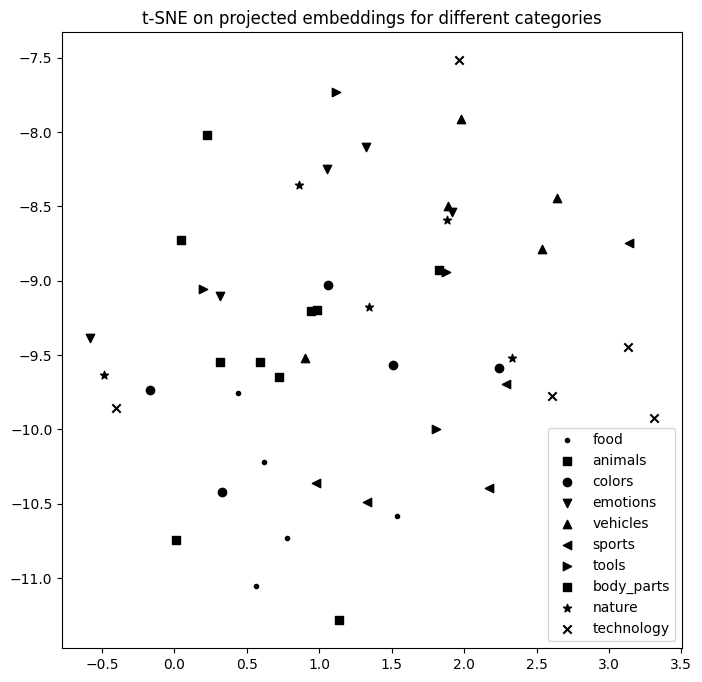

In [27]:
fig = plt.figure(figsize = (8, 8))
markers = ['.', ',', 'o', 'v', '^', '<', '>', 's', '*', 'x', 'D', 'd', 'p', 'h', 'H', '+', '|', '_']
for i, (category, projected_embedding) in enumerate(tsne_projections.items()):
  plt.scatter(projected_embedding[:, 0], projected_embedding[:, 1], label = category, marker = markers[i], color = "black")
plt.legend(loc = 'best')
plt.title("t-SNE on projected embeddings for different categories")

- No clear pattern can be drawn from the t-SNE graph.
- A group can be seen around technology on the right hand side of the graph.

# AI Usage

- None of the code in this repository was written using AI.
- AI was used in helping understand some of the concepts, like saliency scores,U-MAP, and t-SNE, in more depth.